In [2]:
import matplotlib.pyplot as plt
import time
import pickle
import scipy.stats
from scipy import interpolate
from copy import copy
import pandas as pd
from matplotlib.animation import FuncAnimation
from scipy.stats import rv_continuous
from tqdm import tqdm
from itertools import permutations

import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib
import itertools



plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)
plt.rcParams['text.latex.preamble']=r'\usepackage{amsmath,amssymb,physics,bm}'

In [187]:
from importlib import reload

import GTN
reload(GTN)
from GTN import *

# Test

In [188]:
gtn=GTN(L=16,seed=1,op=False,random_init=True)
# gtn.set(ij_list=[[0,1]],n_list=[-1])

In [189]:
def measure_feedback_layer():
    for i in range(1,gtn.L//2,2):
        # print([i,(i+1)%(gtn.L//2)])
        gtn.measure_feedback_AIII([i,(i+1)%(gtn.L//2)],feedback=True)

In [190]:

def randomize():
    for i in range(gtn.L,2*gtn.L):
        print([i, (i+1)%(2*gtn.L)])
        gtn.randomize([i, (i+1)%(2*gtn.L)])


In [191]:
measure_feedback_layer()
randomize()
measure_feedback_layer()

[18, 19] [20, 21]
[22, 23] [24, 25]
[26, 27] [28, 29]
[30, 31] [16, 17]
[16, 17]
[17, 18]
[18, 19]
[19, 20]
[20, 21]
[21, 22]
[22, 23]
[23, 24]
[24, 25]
[25, 26]
[26, 27]
[27, 28]
[28, 29]
[29, 30]
[30, 31]
[31, 0]
[18, 19] [20, 21]
[22, 23] [24, 25]
[26, 27] [28, 29]
[30, 31] [16, 17]


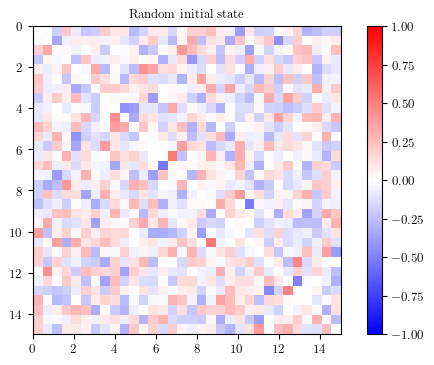

In [249]:
fig,ax=plt.subplots()
i=0
im=ax.imshow(gtn.C_m_history[i],cmap='bwr',vmin=-1,vmax=1,extent=[0,gtn.L-1,gtn.L-1,0])
plt.colorbar(im)
if i>0:
    ax.set_title(parse_text(gtn.n_history[i-1], gtn.i_history[i-1]))
else:
    ax.set_title('Random initial state')

## Create animation

In [250]:
import matplotlib.animation as animation

In [251]:
def update(frame):
    im.set_data(gtn.C_m_history[frame])
    if frame > 0:
        ax.set_title(parse_text(gtn.n_history[frame-1], gtn.i_history[frame-1]))
    else:
        ax.set_title('Random initial state')
    return im, ax

In [252]:
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=range(35),  # Generate frames from 0 to 40
    blit=False    # Blit optimizes the rendering
)

In [253]:
ani.save('animation_1.mp4', writer='ffmpeg', fps=1,dpi=200)

In [ ]:
def parse_text(n_history,i_history):
    

In [166]:
# def parse_text(n_history,i_history):
#     if len(i_history) ==4 and len(n_history)==4 and len(n_history[-1])==2:
#         return parse_top(n_history,i_history)
#     if len(i_history) ==2 and len(n_history)==3 and np.abs(n_history[0])==1:
#         return parse_bottom(n_history,i_history)
#     if len(i_history) ==6 and len(n_history)==2 and n_history[1] is None:
#         return parse_top_to_bottom(n_history,i_history)
#     if len(i_history) ==6 and len(n_history)==2 and n_history[0] is None:
#         return parse_bottom_to_top(n_history,i_history)
#     if len(i_history) ==4 and len(n_history)==2 and (n_history[0] is not None) and (n_history[1] is not None):
#         return parse_top_flip(n_history,i_history)
#     if len(i_history) ==2 and len(n_history)==3 and np.abs(n_history[0])<1:
#         return parse_randominze(n_history,i_history)


In [94]:
len(gtn.n_history[2])

1

In [193]:
gtn.n_history[0], gtn.i_history[0]

(([1, -1], 0), [2, 3, 4, 5])

In [239]:
gtn.n_history[23], gtn.i_history[23]

(array([ 0.       , -0.7714907, -0.6362406]), [16, 17])

In [241]:
parse_text(gtn.n_history[23], gtn.i_history[23])

'Random unitary on ($\\gamma_0$,bottom) and ($\\bar{\\gamma}_0$,bottom)'

In [221]:
gtn.n_history[5]

[[1, 1], [1]]

In [220]:
gtn.i_history[5]

[2, 3, 4, 5, 20, 21]

In [240]:
def parse_text(n_history,i_history):
    if len(i_history) ==2 and len(n_history)==3 and np.abs(n_history[0])<1:
        return parse_randominze(n_history,i_history)
    if len(i_history)<=4:
        return parse_single_mode(n_history,i_history)
    if len(i_history)==6:
        return parse_fSWAP(n_history,i_history)
    


In [235]:
def parse_single_mode(n_history,i_history):
    mode, n = n_history
    if mode == [1]:
        idx=(i_history[0] - gtn.L)//2
        return f'Measure ({idx},bottom) with charge {n}'
    if mode == [1,1] or mode == [1,-1]:
        idx = i_history
        return f'Measure the mode ({idx[0]//2},top {"+" if mode[1]==1 else "-"} {idx[2]//2},top) with charge {n}'


In [248]:
def parse_fSWAP(n_history,i_history):
    mode , _ =n_history
    idx = i_history
    return f'Swap between ({idx[0]//2},top {"+" if mode[1]==1 else "-"} {idx[2]//2},top) and {(idx[4]-gtn.L)//2} bottom'

In [225]:
parse_fSWAP(gtn.n_history[5],gtn.i_history[5])

'Swap between (1,top + 2,top) and 2'

In [ ]:
for i in range(len(gtn.n_history)):
    parse_text(gtn.n_history[i],gtn.i_history[i]) 

In [ ]:
parse_single_mode(gtn.n_history[1],gtn.i_history[1])

'Measure (2,bottom) with charge 1'

In [177]:
def parse_top(n_history,i_history):
    kind = n_history[-1]
    idx = i_history
    outcome={(-1,-1):'00',(-1,1):'-',(1,-1):'+',(1,1):'11'}
    return f'Measure ({idx[0]//2},top and {idx[2]//2},top) with outcome $|{outcome[kind]}\\rangle$'

def parse_bottom(n_history,i_history):
    kind = n_history[0]
    outcome = {1:1,-1:0}
    idx=(i_history[0]-gtn.L)//2
    return f'Measure ({idx},bottom) with outcome $|{outcome[kind]}\\rangle$'
def parse_randominze(n_history,i_history):
    idx=[(i-gtn.L)%gtn.L for i in i_history]
    if i_history[0]%2==0:
        return f'Random unitary on ($\gamma_{idx[0]//2}$,bottom) and ($\\bar{{\gamma}}_{idx[1]//2}$,bottom)'
    else:
        return f'Random unitary on ($\\bar{{\gamma}}_{idx[0]//2}$,bottom) and ($\gamma_{idx[1]//2}$,bottom)'

def parse_top_flip(n_history,i_history):
    source=[i_history[0]//2,i_history[2]//2]
    return f'Flip from ({source[0]},top + {source[1]},top) to ({source[0]},top - {source[1]},top)'
def parse_top_to_bottom(n_history,i_history):
    target=(i_history[-2]-gtn.L)//2
    source=[i_history[0]//2,i_history[2]//2]

    return f'Deplete mode ({source[0]},top + {source[1]},top) to ({target},bottom) '

def parse_bottom_to_top(n_history,i_history):
    source=(i_history[-2]-gtn.L)//2
    target=[i_history[0]//2,i_history[2]//2]
    return f'Fill mode ({target[0]},top - {target[1]},top) from ({source},bottom) '


In [179]:
parse_top(gtn.n_history[0], gtn.i_history[0])
# (parse_text(gtn.n_history[32], gtn.i_history[32]))

TypeError: unhashable type: 'list'

In [ ]:
'Transfer '

In [177]:
len(gtn.i_history)

8

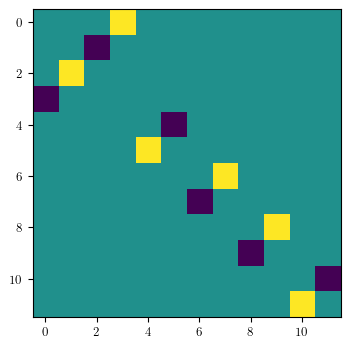

In [139]:
# plt.imshow(op_state_transfer(source=None,target='-t'))
plt.imshow(op_state_transfer(source='+t',target=None))

In [131]:
gtn.state_transfer([12,13,14,15],source='+t',target='-t')

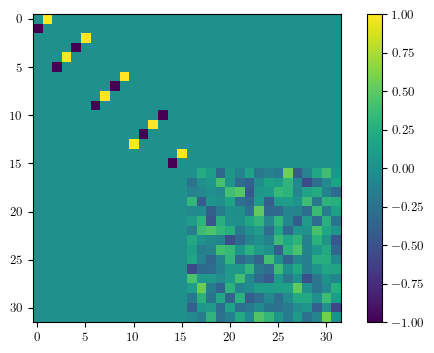

In [125]:
plt.imshow(gtn.C_m)
plt.colorbar()

# Draft

In [60]:
gtn.measure_charge(legs=[0,1])

1.0

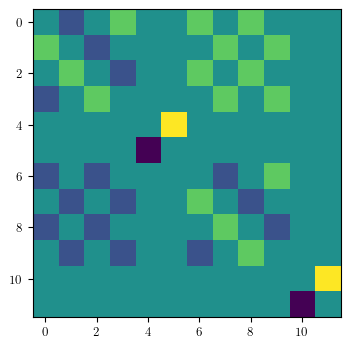

In [197]:
plt.imshow(op_state_transfer(target='-t',source=None))

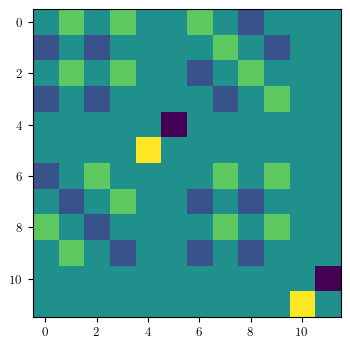

In [196]:
plt.imshow(op_state_transfer(source='+t',target=None))

In [ ]:
op=op_fSWAP(source=[1],target=[1])

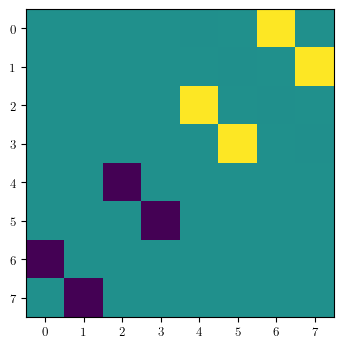

In [ ]:
plt.imshow(op)

In [ ]:
gtn.measure_charge([0,1])

-1.0

In [ ]:
gtn.measure_projection_AIII([2,3,4,5,])

(-1, 1)

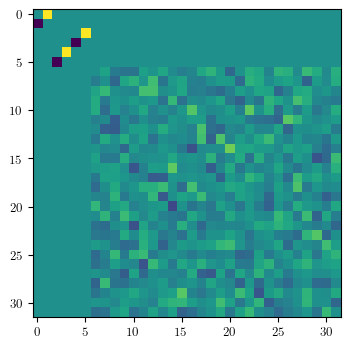

In [ ]:
plt.imshow(gtn.C_m)

In [ ]:
|0> |+=0>|-=1>

In [59]:
op=op_fSWAP(state1=[1,],state2=[1,1])
# op=op_fSWAP(source=[1,-1],target=[1,])

In [60]:
P_contraction_2(gtn.C_m,op,ix=range(6),ix_bar=range(6,gtn.C_m.shape[0]))

In [ ]:
P_contraction_2(gtn.C_m,op,ix=[0,1,4,5],ix_bar=[2,3]+list(range(6,gtn.C_m.shape[0])))

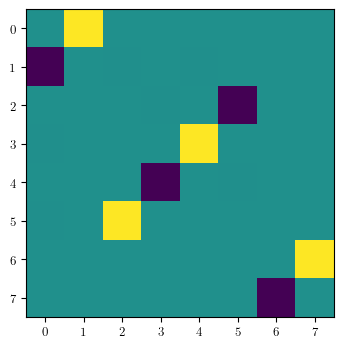

In [61]:
plt.imshow(gtn.C_m)

In [ ]:
gtn.C_m[:2,:2]

array([[ 0.        , -0.15160414],
       [ 0.15160414,  0.        ]])

In [ ]:
get_Born(gtn.C_m[0:2,0:2],[1])

(0.5758020706734386+0j)

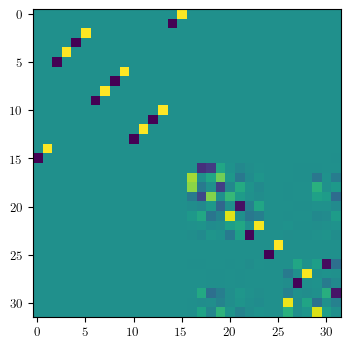

In [ ]:
plt.imshow(gtn.C_m_history[-1])

In [ ]:
get_Born()

In [ ]:
S= np.kron(np.eye(gtn.C_m.shape[0]//2),np.array([[1,1j],[1,-1j]])/2)

In [ ]:
cf=S @ (np.eye(gtn.C_m.shape[0])- 1j *gtn.C_m )@ S.conj().T

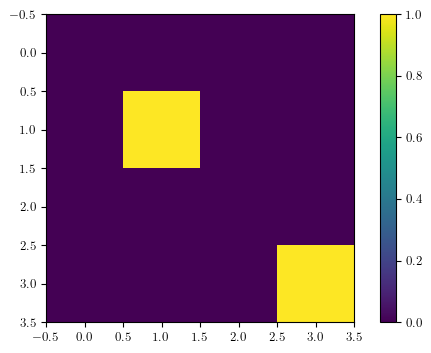

In [ ]:
plt.imshow(cf.real)
plt.colorbar()

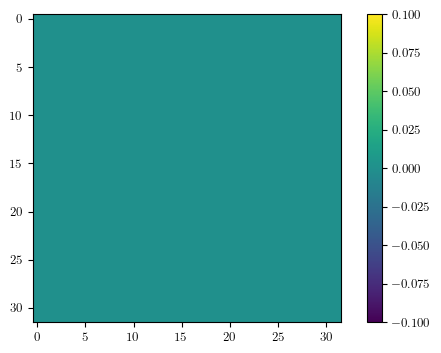

In [ ]:
plt.imshow(cf.imag)
plt.colorbar()

In [ ]:
C_m=gtn.C_m.copy()

In [ ]:
C_m_c= C_m.conj()

In [ ]:
op_up=Gamma_othor(u=[1,1],epsilon11=np.array([[0,1],[-1,0]]),epsilon12=np.zeros((2,2)))

In [ ]:
op_low=Gamma_othor(u=[1,-1],epsilon11=np.array([[0,-1],[1,0]]),epsilon12=np.zeros((2,2)))

In [ ]:
op = op_single_mode(([1],0))

In [ ]:
op_c=op.copy()

In [ ]:
op.shape

(8, 8)

In [ ]:
P_contraction_2(op_c,op,ix=range(4,8),ix_bar = range(4))

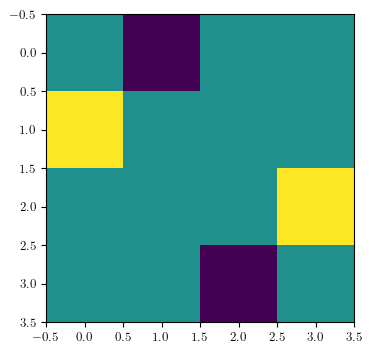

In [ ]:
plt.imshow(op)

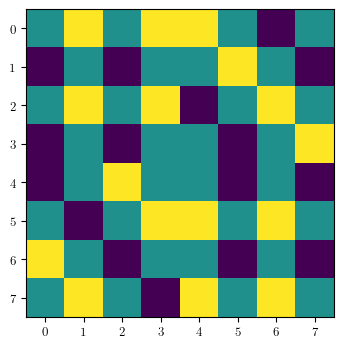

In [ ]:
plt.imshow(op_c)